In [1]:
import numpy as np
from scipy import signal
from scipy.interpolate import interp1d
from scipy.signal import butter, filtfilt#, iirdesign, zpk2tf, freqz
import scipy.fftpack as sfft

In [2]:
%matplotlib notebook

In [3]:
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from matplotlib.colors import Normalize
import h5py
from tqdm import tqdm_notebook as tqd
import readligo as rl

#### Import the LIGO files 

In [4]:
fn_L1 = 'L-L1_GWOSC_4KHZ_R1-1186741846-32.hdf5'
fn_H1 = 'H-H1_LOSC_4_V1-1126259446-32.hdf5'
strain_H1, time_H1, chan_dict_H1 = rl.loaddata(fn_H1, 'H1')
strain_L1, time_L1, chan_dict_L1 = rl.loaddata(fn_L1, 'L1')

readligo.py:132: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  shortnameArray = dqInfo['DQShortnames'].value
readligo.py:138: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  injnameArray = injInfo['InjShortnames'].value
readligo.py:143: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  gpsStart = meta['GPSstart'].value


In [5]:
# sampling rate:
fs = 4096

#the time sample interval
dt_H1 = time_H1[1] - time_H1[0]
dt_L1 = time_L1[1] - time_L1[0]

t_L1 = 1186741861.5
t_H1 = 1126259462.422
deltat = 5

true_chirp_mass_H1 = 28.6
true_chirp_mass_L1 = 24.2

In [6]:
def window_index(tevent, deltat, time):
    indxt = np.where((time >= tevent-deltat) & (time < tevent+deltat))
    return indxt

<IPython.core.display.Javascript object>


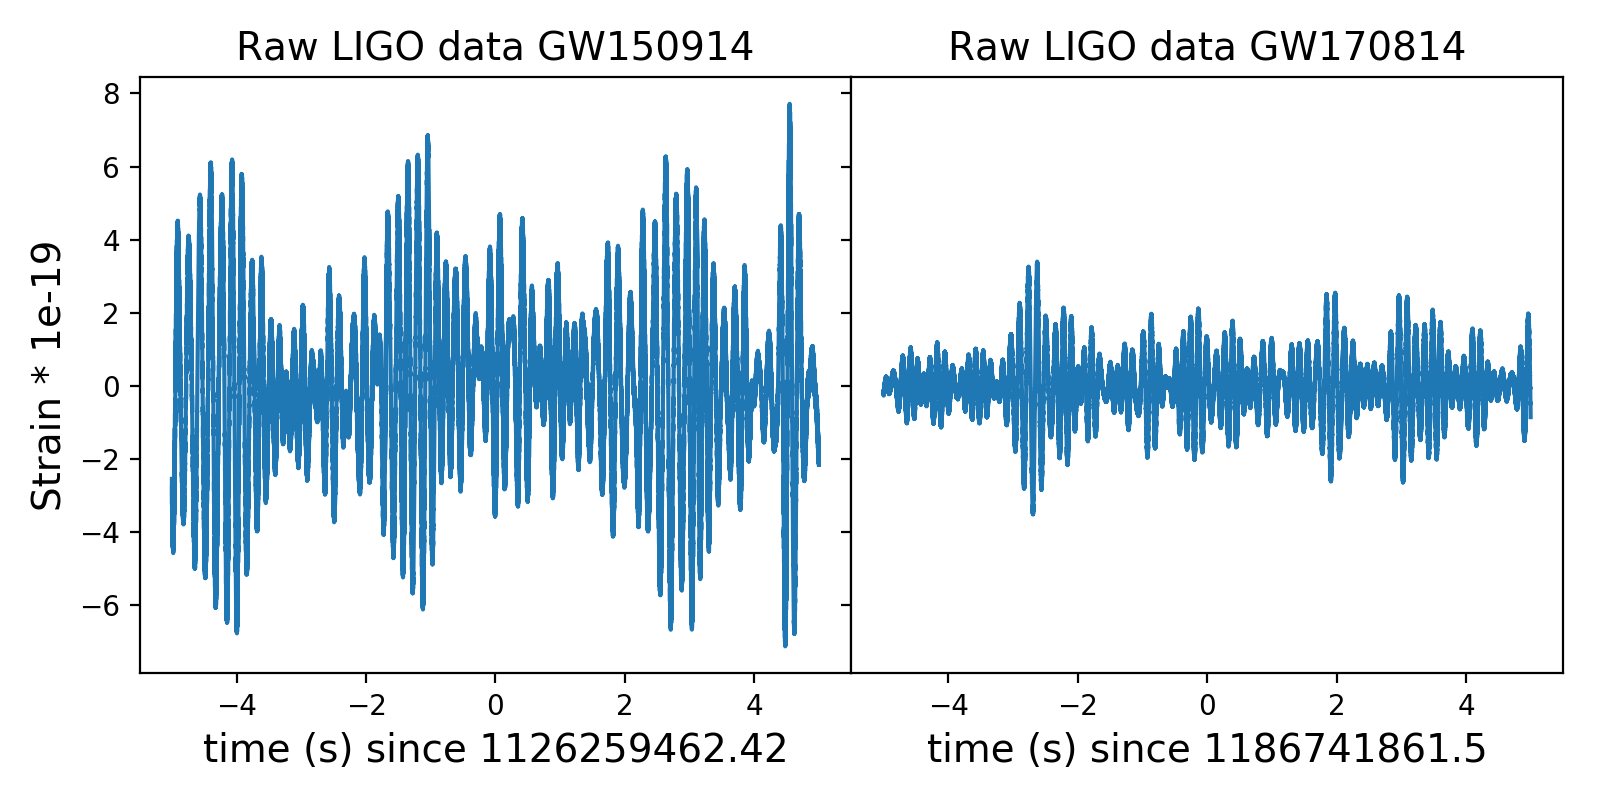

In [7]:
indxt_H1 = window_index(t_H1, deltat, time_H1)
indxt_L1 = window_index(t_L1, deltat, time_L1)

fig, axs = plt.subplots(ncols=2, sharey=True, gridspec_kw={'wspace':0.}, figsize=(8,4))
axs[0].plot(time_H1[indxt_H1]-t_H1, strain_H1[indxt_H1]*1e19)
axs[1].plot(time_L1[indxt_L1]-t_L1, strain_L1[indxt_L1]*1e19)
axs[0].set_xlabel('time (s) since ' + str(t_H1), fontsize=14)
axs[1].set_xlabel('time (s) since ' + str(t_L1), fontsize=14)
axs[0].set_ylabel("Strain * 1e-19", fontsize=14)
axs[0].set_title("Raw LIGO data GW150914", fontsize=14)
axs[1].set_title("Raw LIGO data GW170814", fontsize=14)
plt.tight_layout()
#plt.savefig("Raw_LIGO_Plots.pdf")

#### Start cleaning the data

In [8]:
def asd(strain, NFFT, fmin, fmax):
    Pxx, freqs = mlab.psd(strain, Fs=fs, NFFT=NFFT)
    psd = interp1d(freqs, Pxx)
    return psd, Pxx, freqs

In [9]:
NFFT = 1*fs
fmin = 10
fmax = 2000

psd_H1, Pxx_H1, freqs_H1 = asd(strain_H1, NFFT, fmin, fmax)
psd_L1, Pxx_L1, freqs_L1 = asd(strain_L1, NFFT, fmin, fmax)

<IPython.core.display.Javascript object>


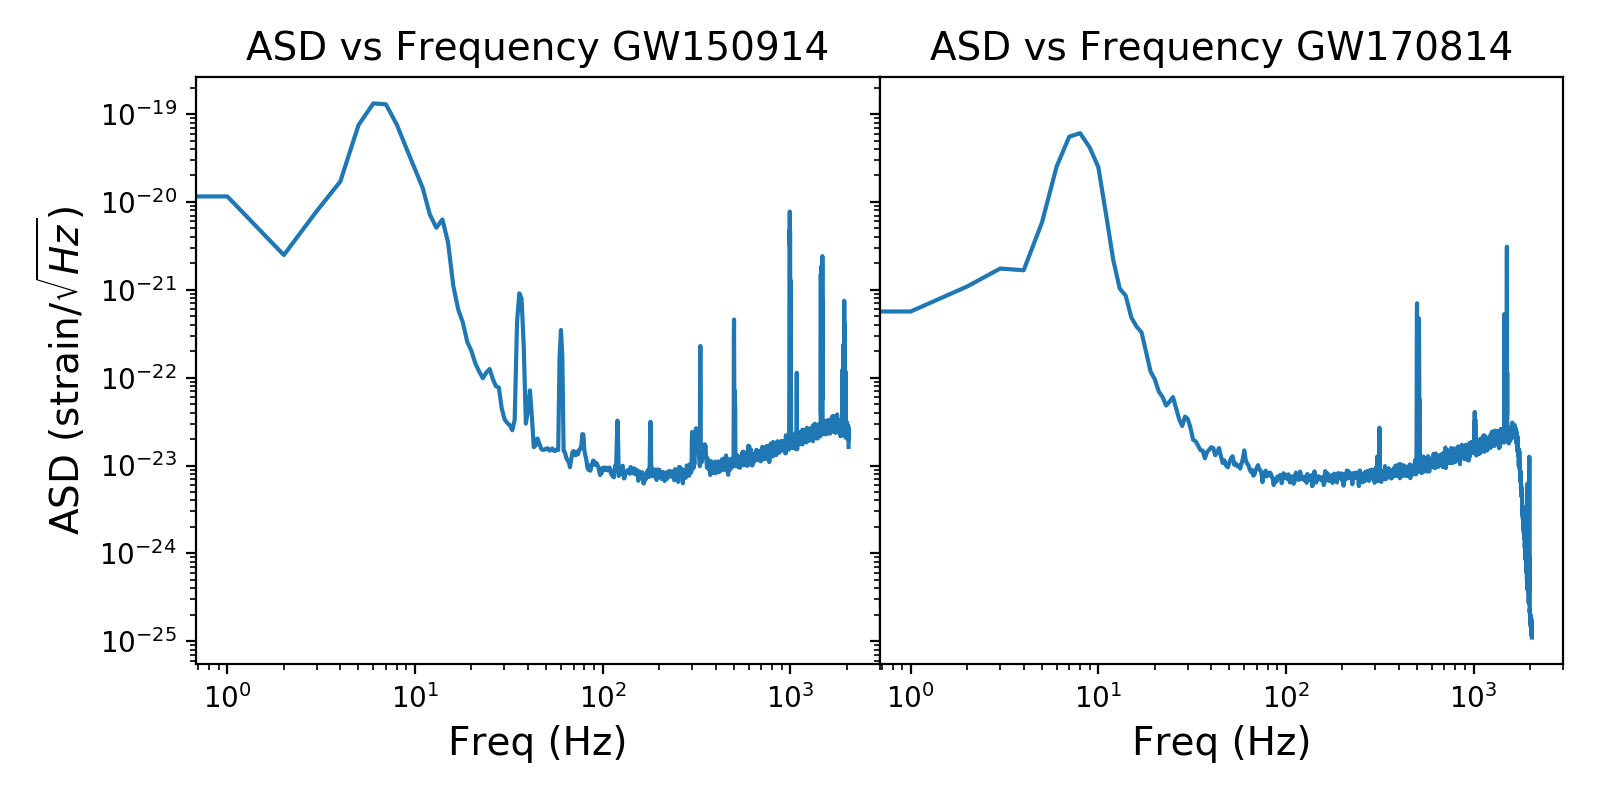

In [10]:
fig, axs = plt.subplots(ncols=2, sharey=True, gridspec_kw={'wspace':0}, figsize=(8,4))
axs[0].loglog(freqs_H1, np.sqrt(Pxx_H1))
axs[1].loglog(freqs_L1, np.sqrt(Pxx_L1))
axs[0].set_xlabel("Freq (Hz)", fontsize=14)
axs[1].set_xlabel("Freq (Hz)", fontsize=14)
axs[0].set_ylabel(r"ASD (strain/$\sqrt{Hz}$)", fontsize=14)
axs[0].set_title("ASD vs Frequency GW150914", fontsize=14)
axs[1].set_title("ASD vs Frequency GW170814", fontsize=14)
plt.tight_layout()
#plt.savefig("ASD_Plots.pdf")

### Now a funciton to "whiten" the data

We will divide the data by the asd, supressing the low frequency noise. 

In [11]:
def whiten(strain, interp_psd, dt):
    Nt = len(strain)
    freqs = np.fft.rfftfreq(Nt, dt)
    
    #whitening: transform to the frequency domain, 
    #   divide by the asd, then transform back, taking
    #   care to get the normalization right
    hf = np.fft.rfft(strain)
    white_hf = hf / (np.sqrt(interp_psd(freqs) /dt/2.0))
    white_ht = np.fft.irfft(white_hf, n=Nt)
    return white_ht

In [12]:
strain_H1_whiten = whiten(strain_H1, psd_H1, dt_H1)
strain_L1_whiten = whiten(strain_L1, psd_L1, dt_H1)

### Now it is time for bandpassing

Bandpassing is a method of passing on frequencies within a certain range and rejecting those outside

In [13]:
def bandpass(strain, fs):
    bb, ab = butter(4, [20.0*2/fs, 300.0*2/fs], btype="band")
    strain_bp = filtfilt(bb, ab, strain)
    return strain_bp

In [14]:
strain_H1_whiten_bp = bandpass(strain_H1_whiten, fs)
strain_L1_whiten_bp = bandpass(strain_L1_whiten, fs)

## Now let's look at the data

We should be able to see the actual gravitational wave signal

<IPython.core.display.Javascript object>


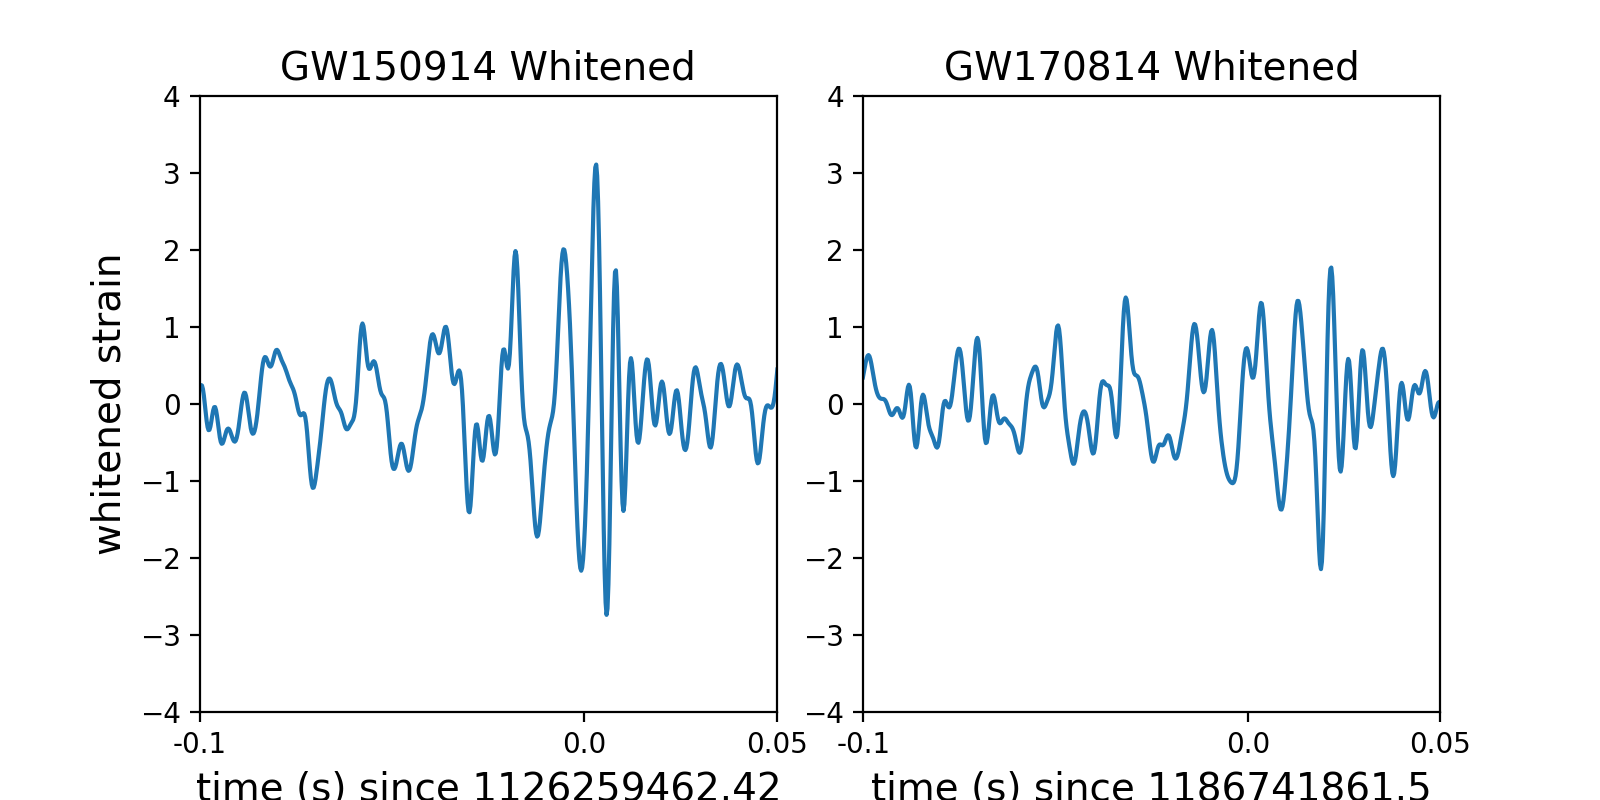

/Users/DanielBautista/opt/miniconda3/envs/ligo-py27/lib/python2.7/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


 Text(0,0,'-0.1'),
 Text(0,0,'0.0'),
 Text(0,0,'0.05'),
 Text(0,0,'-0.1'),
 Text(0,0,'0.0'),
 Text(0,0,'0.05')]

In [15]:
tmin = -0.1
tmax = 0.05

fig, axs = plt.subplots(ncols=2, sharey=False, gridspec_kw={'wspace':0.15}, figsize=(8,4))
axs[0].plot(time_H1-t_H1, strain_H1_whiten_bp)
axs[1].plot(time_L1-t_L1, strain_L1_whiten_bp)
axs[0].set_xlabel("time (s) since " + str(t_H1), fontsize=14)
axs[1].set_xlabel("time (s) since " + str(t_L1), fontsize=14)
axs[0].set_ylabel("whitened strain", fontsize=14)
axs[0].set_title("GW150914 Whitened", fontsize=14)
axs[1].set_title("GW170814 Whitened", fontsize=14)
axs[0].set_xlim(tmin, tmax)
axs[1].set_xlim(tmin, tmax)
axs[0].set_ylim(-4, 4)
axs[1].set_ylim(-4, 4)
axs[0].set_xticks(np.linspace(tmin, tmax, 3, endpoint=True), ())
axs[1].set_xticks(np.linspace(tmin, tmax, 3, endpoint=True), ())
plt.tight_layout()
plt.setp(axs, xticks=[-0.1, 0, 0.05], xticklabels=[-0.1, 0.0, 0.05])
#plt.savefig("Whitened_Plots.pdf")

### Now to look at the signal using a spectrogram

In [16]:
# plot the whitened data, zooming in on the signal region
deltat = 0.5

# index into the strain time series for this time interval
indxt_H1 = np.where((time_H1 >= t_H1-deltat) & (time_H1 < t_H1+deltat))
indxt_L1 = np.where((time_L1 >= t_L1-deltat) & (time_L1 < t_L1+deltat))

NFFT = fs/16
NOVL = NFFT*15/16
window = np.blackman(NFFT)

<IPython.core.display.Javascript object>


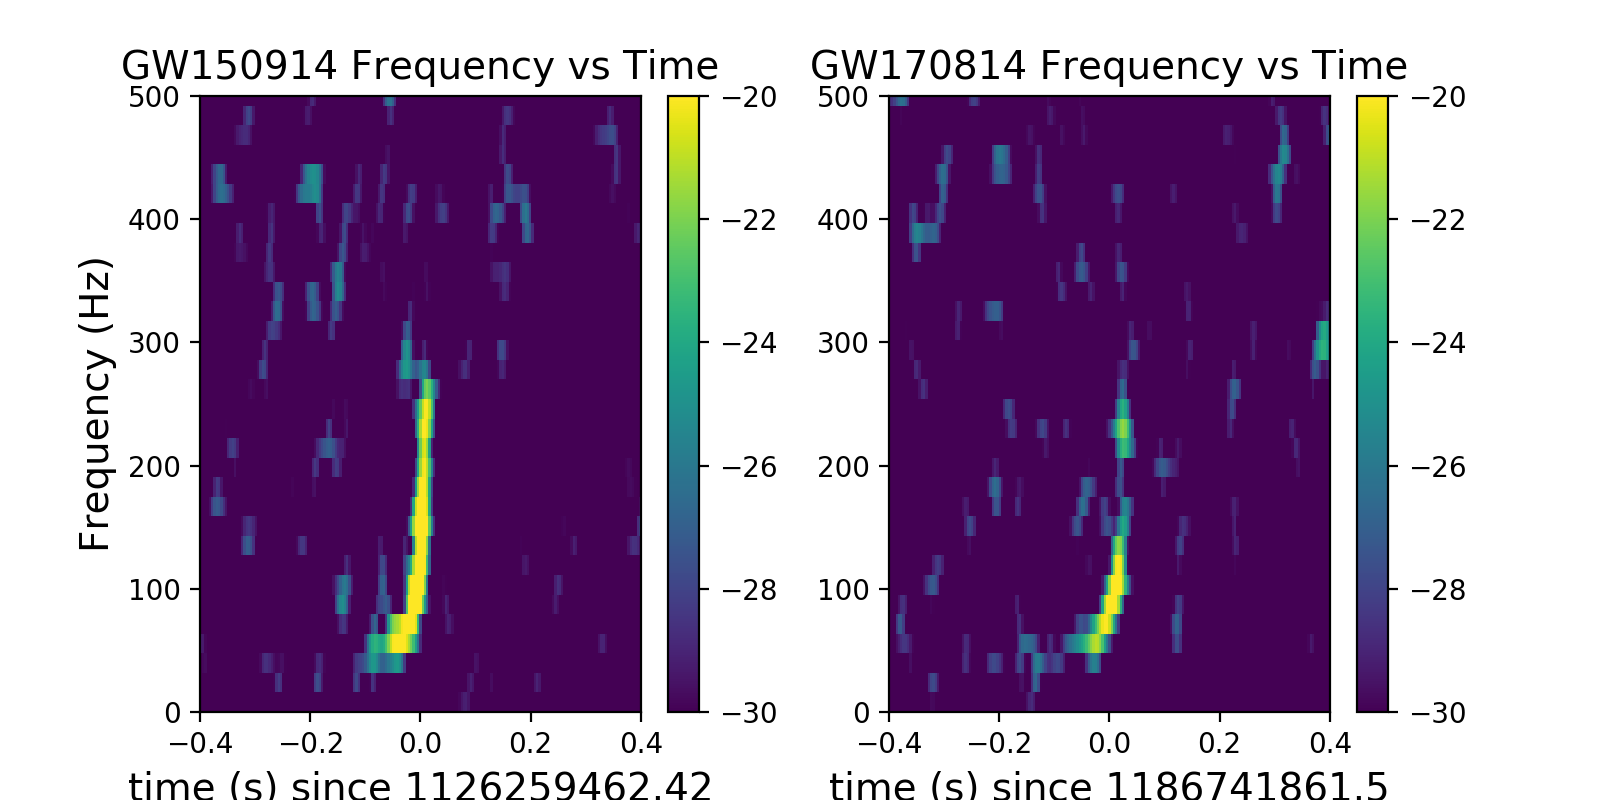

In [17]:
fig, axs = plt.subplots(ncols=2, sharey=False, gridspec_kw={'wspace':0.25}, figsize=(8,4))
spec_H1, freqs_H1, bins_H1, im_H1 = axs[0].specgram(strain_H1_whiten[indxt_H1], NFFT=NFFT, Fs=fs, window=window, noverlap=NOVL, 
                                                    cmap='viridis', xextent=[-deltat,deltat], norm=Normalize(-30,-20))
spec_L1, freqs_L1, bins_L1, im_L1 = axs[1].specgram(strain_L1_whiten[indxt_L1], NFFT=NFFT, Fs=fs, window=window, noverlap=NOVL, 
                                                    cmap='viridis', xextent=[-deltat,deltat], norm=Normalize(-30,-20))
axs[0].set_xlabel("time (s) since " + str(t_H1), fontsize=14)
axs[1].set_xlabel("time (s) since " + str(t_L1), fontsize=14)
axs[0].set_ylabel("Frequency (Hz)", fontsize=14)
#axs[1].set_ylabel("Frequency (Hz)", fontsize=14)
axs[0].set_title("GW150914 Frequency vs Time", fontsize=14)
axs[1].set_title("GW170814 Frequency vs Time", fontsize=14)
axs[0].set_xlim(-0.4, 0.4)
axs[1].set_xlim(-0.4, 0.4)
axs[0].set_ylim(0, 500)
axs[1].set_ylim(0, 500)
fig.colorbar(im_H1, ax=axs[0])
fig.colorbar(im_L1, ax=axs[1])
plt.tight_layout()
#plt.savefig("Spectrograms.pdf")

### Functions to help find the dominant frequency in a given interval

In [18]:
def max_value(arr):
    '''
    This function takes in an array and returns the 
    index of the entry with the maximum value
    '''
    max_val = np.amax(arr)
    max_indx= np.where(arr == max_val)
    return max_indx

In [19]:
def spike_frequency(freqs, fourier_transform, mag=False):
    '''
    This function takes in the raw fourier transform by default 
    and picks out the dominant frequency
    
    If being passed the magnitude, set mag=True
    '''
    if mag:
        pos = max_value(fourier_transform)
        return freqs[pos[0][0]]
    pos = max_value(np.abs(fourier_transform))
    return freqs[pos[0][0]]

In [20]:
def fourier_transform_freq_time(data, start_indx, interval, fs, dt):
    '''
    This function takes in an array of data, a start index, and an interval 
    on which to perform a fourier transform and returns the dominant 
    frequency as well as the midpoint time for the interval 
    '''
    start = start_indx
    stop = start_indx+interval
    data = sfft.fft(data[start:stop])
    freqs= sfft.fftfreq(interval)*fs
    
    spike_freq = spike_frequency(freqs, data)
    
    time = (stop*dt + start*dt)/2
    return time, spike_freq

In [21]:
def transform_loop(data, interval, time_arr, freq_arr, fs, dt):
    '''
    This function takes in a large array of data and an interval on which 
    to perform many small interval fourier transforms to, and returns 
    the time and dominant frequency for each interval
    '''
    for start_index in tqd(range(len(data)-interval), leave=False, desc=str(interval)):
        time, freq = fourier_transform_freq_time(data, start_index, interval, fs, dt)
        time_arr.append(time)
        freq_arr.append(freq)
        start_index = start_index + interval/16
    return time_arr, freq_arr

In [22]:
intervals = [1000, 500, 300, 250, 150, 75]
time_arr_H1 = []
freq_arr_H1 = []
time_arr_L1 = []
freq_arr_L1 = []

for interval in tqd(intervals, leave=False, desc="interval"):
    transform_loop(strain_H1_whiten_bp[indxt_H1], interval, time_arr_H1, freq_arr_H1, fs, dt_H1)
    
for interval in tqd(intervals, leave=False, desc="interval"):
    transform_loop(strain_L1_whiten_bp[indxt_L1], interval, time_arr_L1, freq_arr_L1, fs, dt_L1)

/Users/DanielBautista/opt/miniconda3/envs/ligo-py27/lib/python2.7/site-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


SEJveChjaGlsZHJlbj0oRmxvYXRQcm9ncmVzcyh2YWx1ZT0wLjAsIGRlc2NyaXB0aW9uPXUnaW50ZXJ2YWwnLCBtYXg9Ni4wLCBzdHlsZT1Qcm9ncmVzc1N0eWxlKGRlc2NyaXB0aW9uX3dpZHTigKY=


SEJveChjaGlsZHJlbj0oRmxvYXRQcm9ncmVzcyh2YWx1ZT0wLjAsIGRlc2NyaXB0aW9uPXUnMTAwMCcsIG1heD0zMDk2LjAsIHN0eWxlPVByb2dyZXNzU3R5bGUoZGVzY3JpcHRpb25fd2lkdGjigKY=


SEJveChjaGlsZHJlbj0oRmxvYXRQcm9ncmVzcyh2YWx1ZT0wLjAsIGRlc2NyaXB0aW9uPXUnNTAwJywgbWF4PTM1OTYuMCwgc3R5bGU9UHJvZ3Jlc3NTdHlsZShkZXNjcmlwdGlvbl93aWR0aD3igKY=


SEJveChjaGlsZHJlbj0oRmxvYXRQcm9ncmVzcyh2YWx1ZT0wLjAsIGRlc2NyaXB0aW9uPXUnMzAwJywgbWF4PTM3OTYuMCwgc3R5bGU9UHJvZ3Jlc3NTdHlsZShkZXNjcmlwdGlvbl93aWR0aD3igKY=


SEJveChjaGlsZHJlbj0oRmxvYXRQcm9ncmVzcyh2YWx1ZT0wLjAsIGRlc2NyaXB0aW9uPXUnMjUwJywgbWF4PTM4NDYuMCwgc3R5bGU9UHJvZ3Jlc3NTdHlsZShkZXNjcmlwdGlvbl93aWR0aD3igKY=


SEJveChjaGlsZHJlbj0oRmxvYXRQcm9ncmVzcyh2YWx1ZT0wLjAsIGRlc2NyaXB0aW9uPXUnMTUwJywgbWF4PTM5NDYuMCwgc3R5bGU9UHJvZ3Jlc3NTdHlsZShkZXNjcmlwdGlvbl93aWR0aD3igKY=


SEJveChjaGlsZHJlbj0oRmxvYXRQcm9ncmVzcyh2YWx1ZT0wLjAsIGRlc2NyaXB0aW9uPXUnNzUnLCBtYXg9NDAyMS4wLCBzdHlsZT1Qcm9ncmVzc1N0eWxlKGRlc2NyaXB0aW9uX3dpZHRoPXXigKY=


/Users/DanielBautista/opt/miniconda3/envs/ligo-py27/lib/python2.7/site-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


SEJveChjaGlsZHJlbj0oRmxvYXRQcm9ncmVzcyh2YWx1ZT0wLjAsIGRlc2NyaXB0aW9uPXUnaW50ZXJ2YWwnLCBtYXg9Ni4wLCBzdHlsZT1Qcm9ncmVzc1N0eWxlKGRlc2NyaXB0aW9uX3dpZHTigKY=


SEJveChjaGlsZHJlbj0oRmxvYXRQcm9ncmVzcyh2YWx1ZT0wLjAsIGRlc2NyaXB0aW9uPXUnMTAwMCcsIG1heD0zMDk2LjAsIHN0eWxlPVByb2dyZXNzU3R5bGUoZGVzY3JpcHRpb25fd2lkdGjigKY=


SEJveChjaGlsZHJlbj0oRmxvYXRQcm9ncmVzcyh2YWx1ZT0wLjAsIGRlc2NyaXB0aW9uPXUnNTAwJywgbWF4PTM1OTYuMCwgc3R5bGU9UHJvZ3Jlc3NTdHlsZShkZXNjcmlwdGlvbl93aWR0aD3igKY=


SEJveChjaGlsZHJlbj0oRmxvYXRQcm9ncmVzcyh2YWx1ZT0wLjAsIGRlc2NyaXB0aW9uPXUnMzAwJywgbWF4PTM3OTYuMCwgc3R5bGU9UHJvZ3Jlc3NTdHlsZShkZXNjcmlwdGlvbl93aWR0aD3igKY=


SEJveChjaGlsZHJlbj0oRmxvYXRQcm9ncmVzcyh2YWx1ZT0wLjAsIGRlc2NyaXB0aW9uPXUnMjUwJywgbWF4PTM4NDYuMCwgc3R5bGU9UHJvZ3Jlc3NTdHlsZShkZXNjcmlwdGlvbl93aWR0aD3igKY=


SEJveChjaGlsZHJlbj0oRmxvYXRQcm9ncmVzcyh2YWx1ZT0wLjAsIGRlc2NyaXB0aW9uPXUnMTUwJywgbWF4PTM5NDYuMCwgc3R5bGU9UHJvZ3Jlc3NTdHlsZShkZXNjcmlwdGlvbl93aWR0aD3igKY=


SEJveChjaGlsZHJlbj0oRmxvYXRQcm9ncmVzcyh2YWx1ZT0wLjAsIGRlc2NyaXB0aW9uPXUnNzUnLCBtYXg9NDAyMS4wLCBzdHlsZT1Qcm9ncmVzc1N0eWxlKGRlc2NyaXB0aW9uX3dpZHRoPXXigKY=


In [23]:
time_arr_H1 = np.asarray(time_arr_H1)
freq_arr_H1 = np.asarray(freq_arr_H1)

time_arr_L1 = np.asarray(time_arr_L1)
freq_arr_L1 = np.asarray(freq_arr_L1)

<IPython.core.display.Javascript object>


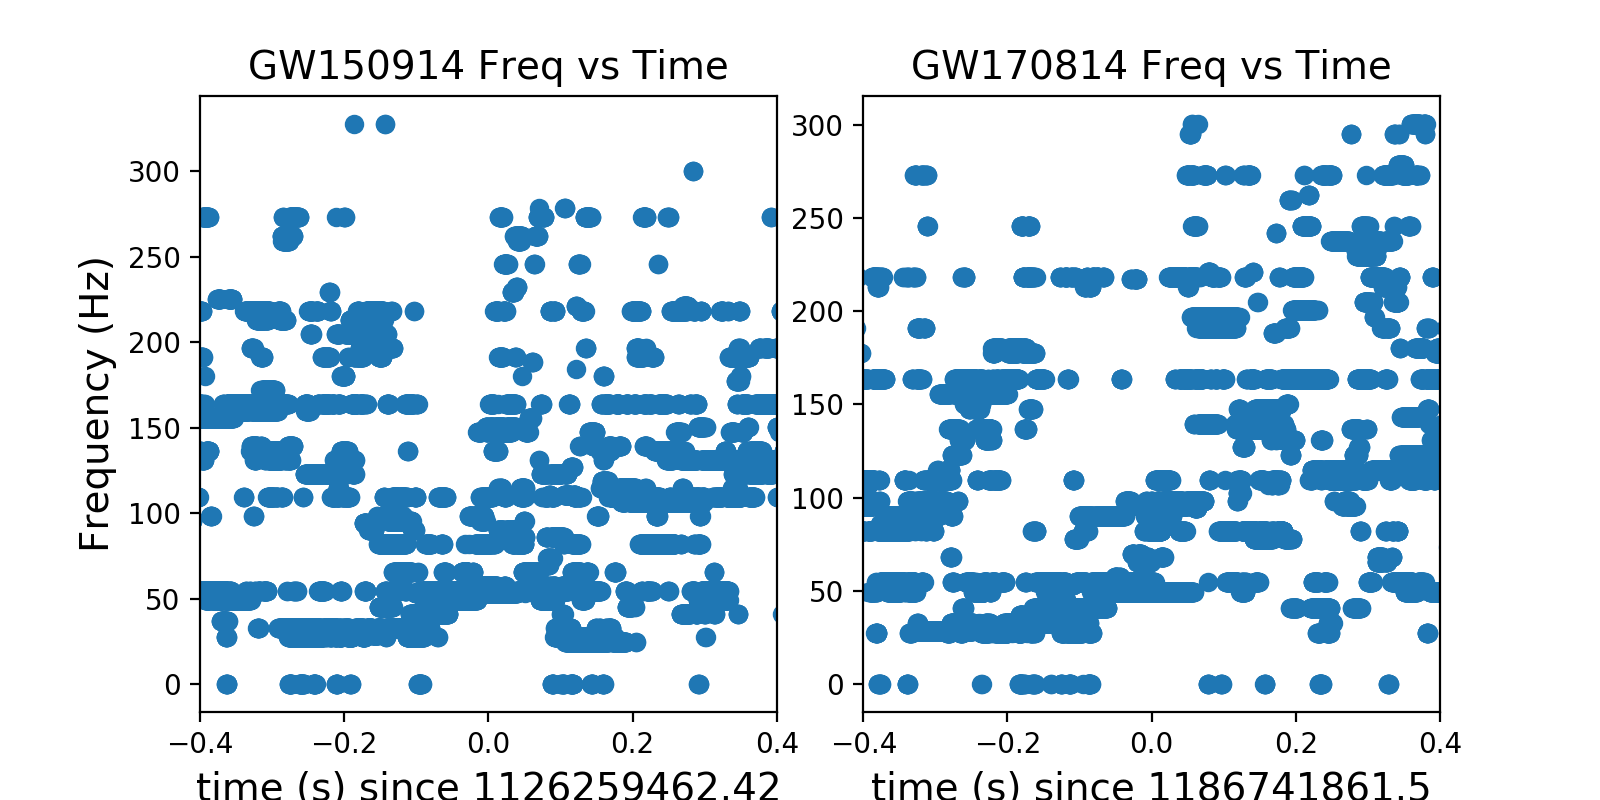

In [24]:
fig, axs = plt.subplots(ncols=2, sharey=False, gridspec_kw={'wspace':0.15}, figsize=(8,4))
axs[0].scatter(time_arr_H1-deltat, np.abs(freq_arr_H1))
axs[1].scatter(time_arr_L1-deltat, np.abs(freq_arr_L1))
axs[0].set_xlabel("time (s) since " + str(t_H1), fontsize=14)
axs[1].set_xlabel("time (s) since " + str(t_L1), fontsize=14)
axs[0].set_ylabel("Frequency (Hz)", fontsize=14)
axs[0].set_title("GW150914 Freq vs Time", fontsize=14)
axs[1].set_title("GW170814 Freq vs Time", fontsize=14)
axs[0].set_xlim(-0.4, 0.4)
axs[1].set_xlim(-0.4, 0.4)
plt.tight_layout()

### Now let's look at this overlayed on the spectrogram

<IPython.core.display.Javascript object>


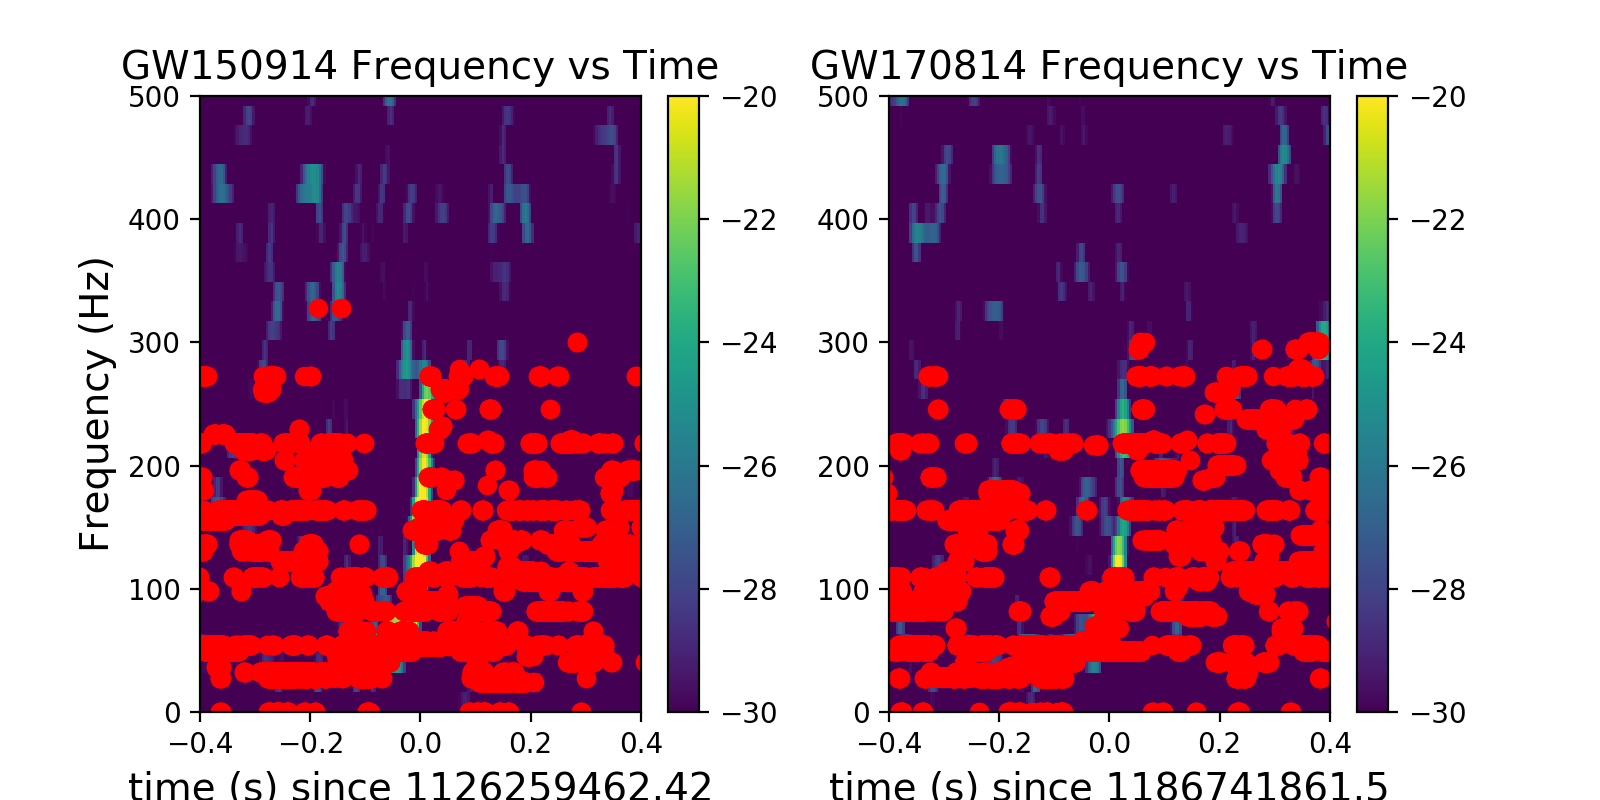

In [25]:
fig, axs = plt.subplots(ncols=2, sharey=False, gridspec_kw={'wspace':0.25}, figsize=(8,4))
spec_H1, freqs_H1, bins_H1, im_H1 = axs[0].specgram(strain_H1_whiten[indxt_H1], NFFT=NFFT, Fs=fs, window=window, noverlap=NOVL, 
                                                    cmap='viridis', xextent=[-deltat,deltat], norm=Normalize(-30,-20))
spec_L1, freqs_L1, bins_L1, im_L1 = axs[1].specgram(strain_L1_whiten[indxt_L1], NFFT=NFFT, Fs=fs, window=window, noverlap=NOVL, 
                                                    cmap='viridis', xextent=[-deltat,deltat], norm=Normalize(-30,-20))
axs[0].scatter(time_arr_H1-deltat, np.abs(freq_arr_H1), color='r')
axs[1].scatter(time_arr_L1-deltat, np.abs(freq_arr_L1), color='r')
axs[0].set_xlabel("time (s) since " + str(t_H1), fontsize=14)
axs[1].set_xlabel("time (s) since " + str(t_L1), fontsize=14)
axs[0].set_ylabel("Frequency (Hz)", fontsize=14)
#axs[1].set_ylabel("Frequency (Hz)", fontsize=14)
axs[0].set_title("GW150914 Frequency vs Time", fontsize=14)
axs[1].set_title("GW170814 Frequency vs Time", fontsize=14)
axs[0].set_xlim(-0.4, 0.4)
axs[1].set_xlim(-0.4, 0.4)
axs[0].set_ylim(0, 500)
axs[1].set_ylim(0, 500)
fig.colorbar(im_H1, ax=axs[0])
fig.colorbar(im_L1, ax=axs[1])
plt.tight_layout()

#### The data looks good! 

I just need to do some cleaning of the data 

In [26]:
def trim(time_arr, freq_arr, deltat, tmin, tmax, fmax):
    interval = np.where((time_arr >= deltat+tmin) & (time_arr < deltat+tmax))
    time_arr = time_arr[interval]
    freq_arr = freq_arr[interval]
    
    to_remove = []
    for i in range(len(time_arr)):
        if freq_arr[i] <= 0 or freq_arr[i] > fmax:
            to_remove.append(i)
            
    time_arr = np.delete(time_arr, to_remove)
    freq_arr = np.delete(freq_arr, to_remove)
    
    return time_arr, freq_arr

In [27]:
new_time_H1, new_freq_H1 = trim(time_arr_H1, freq_arr_H1, deltat, tmin, 0.026, 300)
new_time_L1, new_freq_L1 = trim(time_arr_L1, freq_arr_L1, deltat, tmin, tmax, 300)

#### The data has been trimmed down

Let's see how it looks

<IPython.core.display.Javascript object>


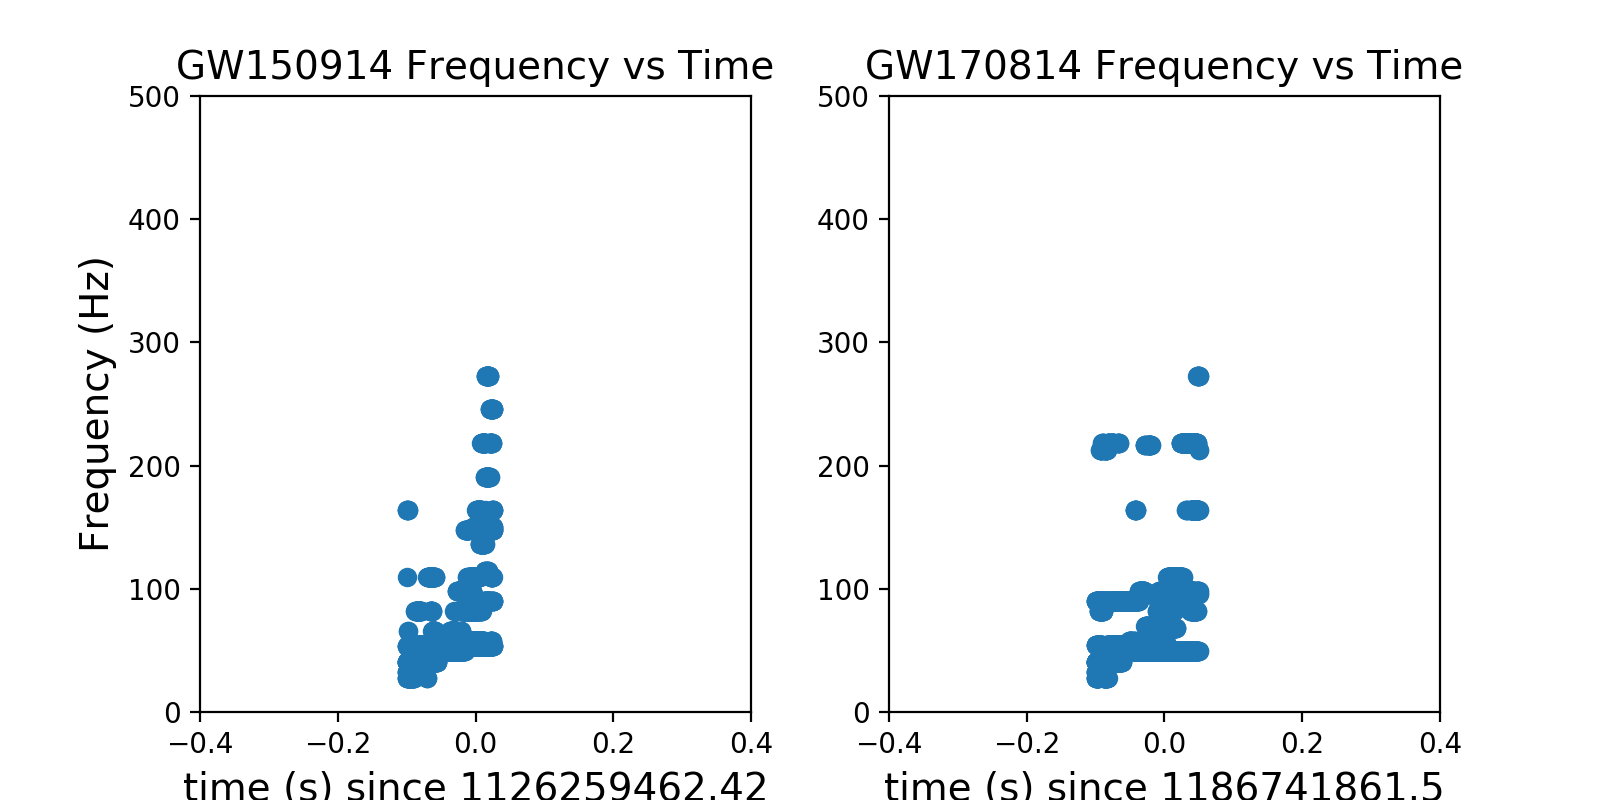

In [28]:
fig, axs = plt.subplots(ncols=2, sharey=False, gridspec_kw={'wspace':0.25}, figsize=(8,4))
axs[0].scatter(new_time_H1-deltat, np.abs(new_freq_H1))
axs[1].scatter(new_time_L1-deltat, np.abs(new_freq_L1))
axs[0].set_xlabel("time (s) since " + str(t_H1), fontsize=14)
axs[1].set_xlabel("time (s) since " + str(t_L1), fontsize=14)
axs[0].set_ylabel("Frequency (Hz)", fontsize=14)
#axs[1].set_ylabel("Frequency (Hz)", fontsize=14)
axs[0].set_title("GW150914 Frequency vs Time", fontsize=14)
axs[1].set_title("GW170814 Frequency vs Time", fontsize=14)
axs[0].set_xlim(-0.4, 0.4)
axs[1].set_xlim(-0.4, 0.4)
axs[0].set_ylim(0, 500)
axs[1].set_ylim(0, 500)
plt.tight_layout()

This looks promising. Let's see how it looks when it's overlayed on the spectrogram.

<IPython.core.display.Javascript object>


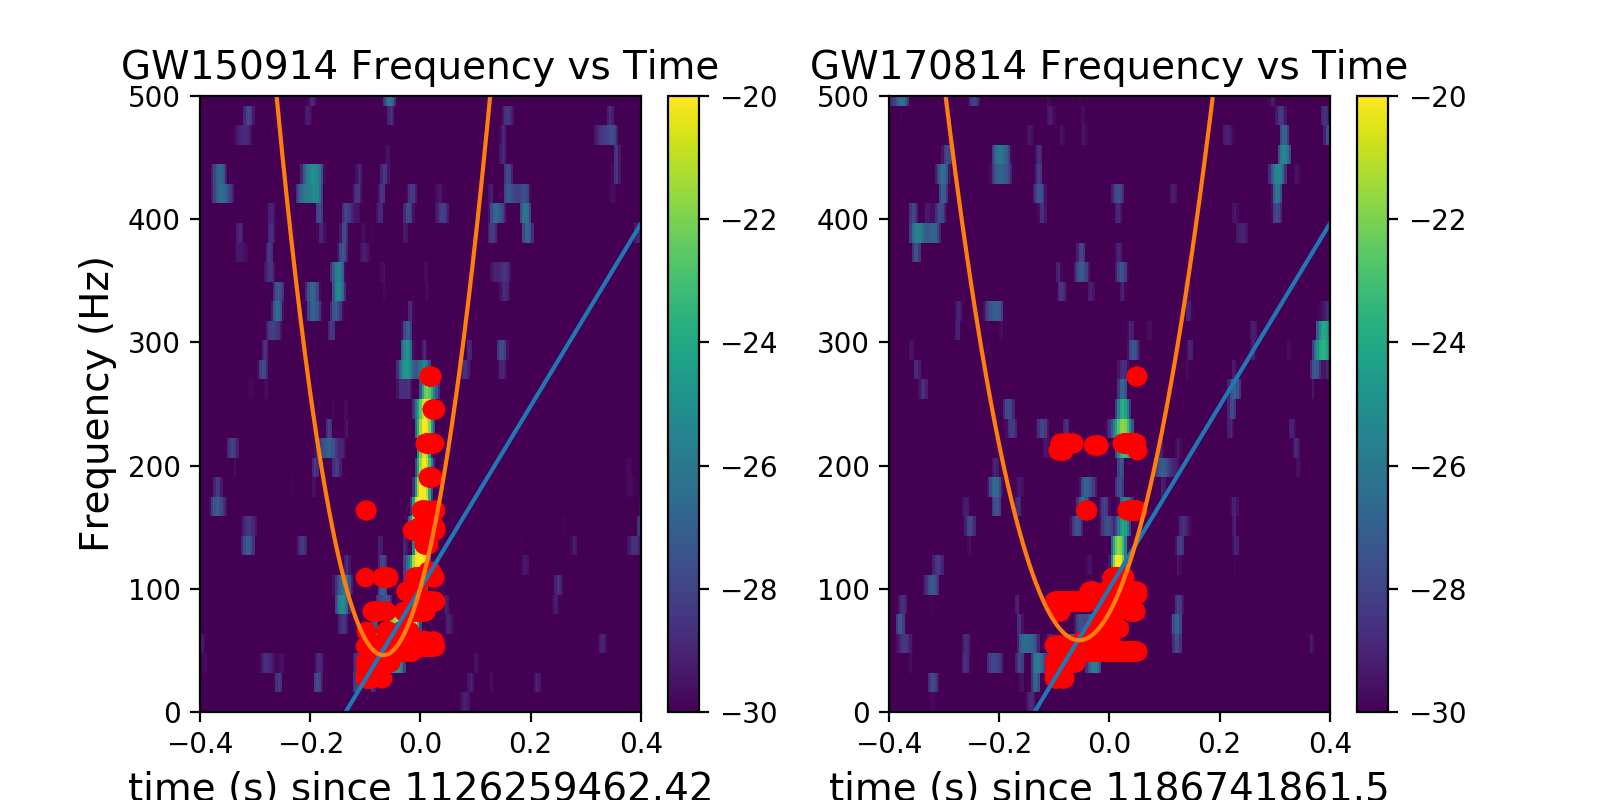

In [29]:
fig, axs = plt.subplots(ncols=2, sharey=False, gridspec_kw={'wspace':0.25}, figsize=(8,4))
spec_H1, freqs_H1, bins_H1, im_H1 = axs[0].specgram(strain_H1_whiten[indxt_H1], NFFT=NFFT, Fs=fs, window=window, noverlap=NOVL, 
                                                    cmap='viridis', xextent=[-deltat,deltat], norm=Normalize(-30,-20))
spec_L1, freqs_L1, bins_L1, im_L1 = axs[1].specgram(strain_L1_whiten[indxt_L1], NFFT=NFFT, Fs=fs, window=window, noverlap=NOVL, 
                                                    cmap='viridis', xextent=[-deltat,deltat], norm=Normalize(-30,-20))
axs[0].scatter(new_time_H1-deltat, np.abs(new_freq_H1), color='r', label="Time vs Freq Scatter")
axs[1].scatter(new_time_L1-deltat, np.abs(new_freq_L1), color='r', label="Time vs Freq Scatter")
axs[0].set_xlabel("time (s) since " + str(t_H1), fontsize=14)
axs[1].set_xlabel("time (s) since " + str(t_L1), fontsize=14)
axs[0].set_ylabel("Frequency (Hz)", fontsize=14)
#axs[1].set_ylabel("Frequency (Hz)", fontsize=14)
axs[0].set_title("GW150914 Frequency vs Time", fontsize=14)
axs[1].set_title("GW170814 Frequency vs Time", fontsize=14)
axs[0].set_xlim(-0.4, 0.4)
axs[1].set_xlim(-0.4, 0.4)
axs[0].set_ylim(0, 500)
axs[1].set_ylim(0, 500)
#axs[0].legend()
#axs[1].legend()
fig.colorbar(im_H1, ax=axs[0])
fig.colorbar(im_L1, ax=axs[1])
plt.tight_layout()
#plt.savefig("Scatter_Plus_Spectrogram.pdf")

## That is very good

Now it is time to try to fit a line to it 

In [30]:
t = np.linspace(-0.5, 0.5, 1000)
m_H1, b_H1 = np.polyfit(new_time_H1-deltat, new_freq_H1, 1)
y_H1 = m_H1*t + b_H1
axs[0].plot(t, y_H1)

m_L1, b_L1 = np.polyfit(new_time_L1-deltat, new_freq_L1, 1)
y_L1 = m_H1*t + b_H1
axs[1].plot(t, y_L1)

It fits alright, but is fairly off in some parts. Let's try a second order curve now

In [31]:
a_H1, b_H1, c_H1 = np.polyfit(new_time_H1-deltat, new_freq_H1, 2)
y_H1 = a_H1*t*t + b_H1*t + c_H1
axs[0].plot(t, y_H1)

a_L1, b_L1, c_L1 = np.polyfit(new_time_L1-deltat, new_freq_L1, 2)
y_L1 = a_L1*t*t + b_L1*t + c_L1
axs[1].plot(t, y_L1)

In [32]:
#plt.savefig("Spectrogram_Fit.pdf")

In [33]:
def chirp_mass(frq, dfdt):
    c = 3.0e8
    G = 6.67e-11
    m_sun = 1.989e30
    
    chirp_mass = (c**3.0/G) * ((5.0/96.0) * np.pi**(-8.0/3.0) * frq**(-11.0/3.0) * dfdt)**(3.0/5.0)
    return chirp_mass/m_sun

In [34]:
def derive_frequency(a, b, c, m):
    x = (m-b)/(2*a)
    f = a*x**2 + b*x + c
    return f

In [35]:
dfdt_H1 = m_H1
dfdt_L1 = m_L1

(m_H1 - b_H1)/(2*a_H1)

frequency_H1 = derive_frequency(a_H1, b_H1, c_H1, m_H1)
frequency_L1 = derive_frequency(a_L1, b_L1, c_L1, m_L1)

In [36]:
chirp_mass_H1 = chirp_mass(frequency_H1, dfdt_H1)
chirp_mass_L1 = chirp_mass(frequency_L1, dfdt_L1)
print "Chirp Mass GW150914:", chirp_mass_H1, "M sun"
print "Chirp Mass GW170814:", chirp_mass_L1, "M sun"

Chirp Mass GW150914: 39.291398786239895 M sun
Chirp Mass GW170814: 22.22407220531382 M sun


In [37]:
def percent_err(true, result):
    percent = np.abs(true-result)*100/true
    return percent

In [38]:
print "Percent error GW150914:", percent_err(true_chirp_mass_H1, chirp_mass_H1)
print "Percent error GW170814: ", percent_err(true_chirp_mass_L1, chirp_mass_L1)

Percent error GW150914: 37.38251323860103
Percent error GW170814:  8.16499088713297
